# Bayesian model comparison
In this notebook, I fit the cortical profiles of decoding accuracies with a linear model and a sine model using Bayesian inference. This is done for Bayesian model comparisons by estimating the WAIC (Watanabe-Akaike information criterion) parameter. Decoding profiles increases toward the cortical surface similar to percent signal changes. Therefore, a linear model would be appropriate to describe the data. However, if the peak in deeper layers is meaningful, i.e. can be related to the thalamocortical input from LGN, a sinusoidal model might capture the peak in deeper layers. A similar model comparison was performend in De Hollander et al., (Neuroimage, 2021) to compare linear and quadratic models for decoding profiles.

Due to the few and noisy data, prior distributions of frequency and phase lag for the sine model were assumed to be rather tight and therefore have the risk to overfit the data. Therefore, interpretation should be cautious. The frequency and phase of the sine curve were adjusted to have a peak in deeper layers as expected from neurophysiology.

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.bayes import LinearModel, SineModel

# set
SESS = "VASO"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b0, b1, y_sigma]


Sampling 4 chains for 500 tune and 10_000 draw iterations (2_000 + 40_000 draws total) took 15 seconds.


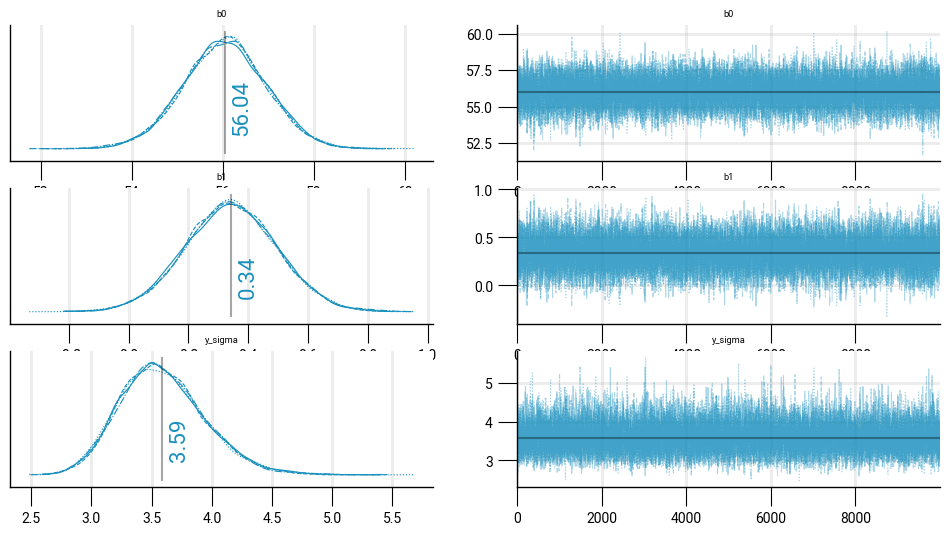

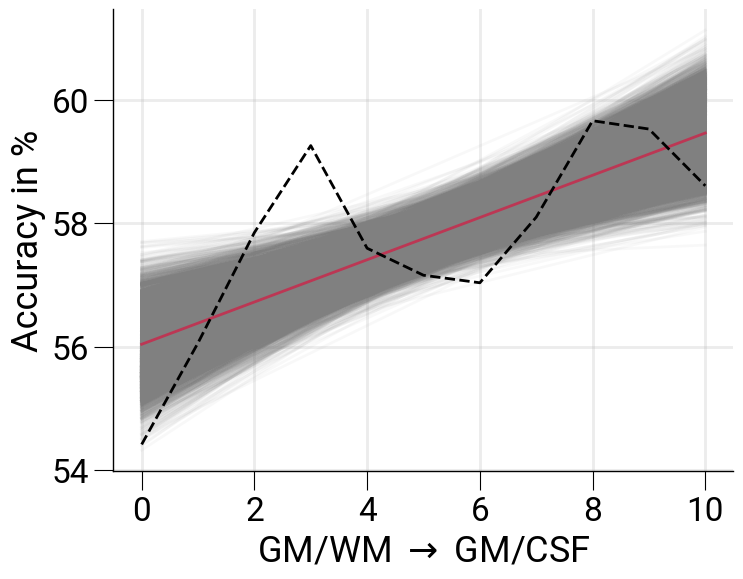

Computed from 40000 posterior samples and 55 observations log-likelihood matrix.

              Estimate       SE
deviance_waic   297.61     7.55
p_waic            2.17        -


In [2]:
lin_mod = LinearModel.from_data(SESS)
lin_mod.sample()
lin_mod.plot_traces()
lin_mod.plot_fit()
lin_mod.evaluate_model("waic")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b0, b1, b2, b3, y_sigma]


Sampling 4 chains for 500 tune and 10_000 draw iterations (2_000 + 40_000 draws total) took 17 seconds.


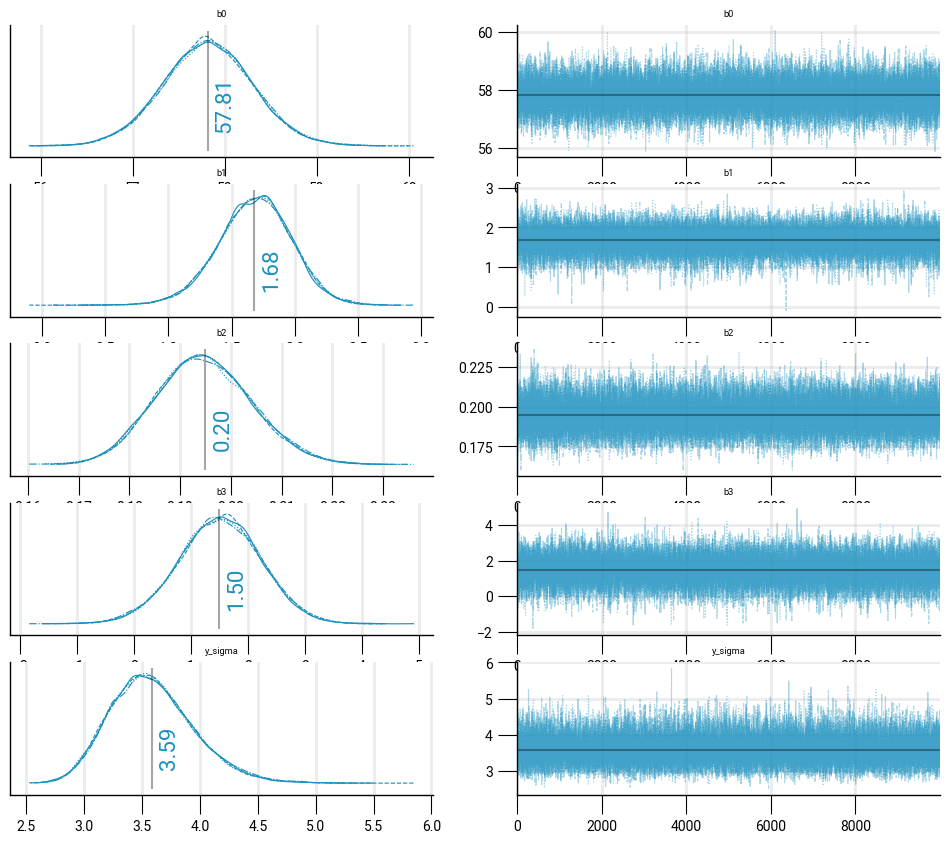

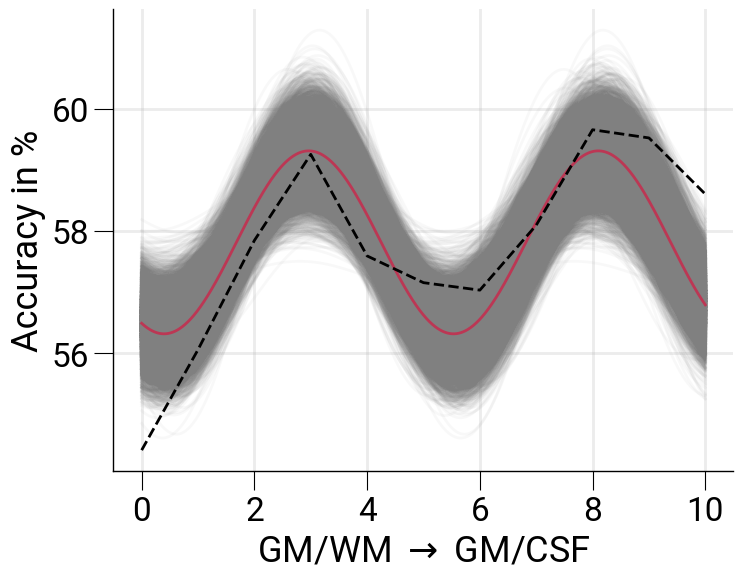

Computed from 40000 posterior samples and 55 observations log-likelihood matrix.

              Estimate       SE
deviance_waic   298.76     7.81
p_waic            3.25        -


In [3]:
cos_mod = SineModel.from_data(SESS)
cos_mod.sample()
cos_mod.plot_traces()
cos_mod.plot_fit()
cos_mod.evaluate_model("waic")